# Topic Modelling and Natural Language Understanding with Persistent Homology

In [76]:
text = ["In the early hours of the morning, after a hearty breakfast, the explorers set out on their journey. They made their way through thick and thin, forging a path through the dense forest under the clear blue sky. They hoped to catch sight of the elusive wildlife known to inhabit the area. Along the way, they encountered a steep hill. With a burst of energy, they climbed to the top and took in the breathtaking view. The landscape stretched out as far as the eye could see, from the rolling green hills to the deep blue sea. They took a few moments to savor the peace and tranquility before moving on. As the day drew to a close, they set up camp under the twinkling stars. They had a bite to eat, shared stories around the campfire, and then retired for the night, eager to see what adventures the next day would bring.", 
        
        "Late in the afternoon, a group of friends decided to embark on a fishing trip. They had been through thick and thin together and shared a common love for the great outdoors. After packing their gear and provisions, they hopped into their old but reliable boat and set off towards the deep blue sea. The day was perfect for fishing, with a cloudless sky and a gentle breeze. They spent hours casting their lines, chatting, and enjoying the serenity of the open water. As the sun began to set, they found a quiet spot to anchor for the night. Beneath the stunning canvas of stars, they prepared a simple meal, swapping tales and laughing at old memories. The quiet lapping of the waves against the boat lulled and the clear blue sky them into a peaceful sleep, their dreams filled with the anticipation of the following day's catch.",

        "The basketball team from our local high school was at the top of their game. They had a habit of pulling rabbits out of hats during every match, turning the tide at the last minute. Their coach, an old hand at the game, had a keen eye for detail and an ability to whip the team into shape. He was a firm believer in the saying, there's no 'I' in 'team'. The star player, an all-rounder, had the knack for scoring points in the nick of time. The spectators, holding their breath in anticipation, would often break into applause at the sight of the home team's stellar performance.",

        "The software development team at our company was at the top of their game. They had a habit of pulling rabbits out of hats during every project, turning the tide at the last minute. Their manager, an old hand at programming, had a keen eye for detail and an ability to whip the team into shape. He was a firm believer in the saying, there's no 'I' in 'team'. The lead developer, an all-rounder, had the knack for solving problems in the nick of time. The clients, holding their breath in anticipation, would often break into applause at the sight of the team's stellar performance.", 

        "In the heart of the bustling city, a small magic shop drew the attention of passersby with its unusual window displays. The owner, a retired magician, was famous for his ability to keep pulling rabbits out of hats, no matter how many times he had seemingly emptied them. His shop was a treasure trove of mysterious artifacts, enchanted props, and old books filled with forgotten spells. He would often perform impromptu magic shows for customers, effortlessly switching between levitating objects, disappearing acts, and card tricks. The climax of these shows would always see him pulling a rabbit out of an ostensibly empty hat, leaving the audience in stunned silence before they would invariably break into applause.", 

        "The tech start-up, nestled in a nondescript office park, was not much to look at from the outside. Yet, the team of engineers and designers inside were on the cutting edge of innovation, consistently pulling rabbits out of hats with their groundbreaking designs. Their latest product was a revolutionary smartwatch that boasted capabilities far beyond any existing model. During product launches, the CEO, a charismatic figure, would take to the stage and unveil the new device. As he demonstrated its features, like holographic displays and energy-efficient bio-sensors, the audience would watch in awe. As the presentation came to a close, showcasing a surprising feature - a mini drone that could detach from the watch and fly around for short distances - the crowd would invariably break into applause."]

In [77]:
import numpy as np
import gudhi as gd
import torch
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt



def compute_output(sentence, layer, head):
    '''
    Computes the "context vectors" of a given head in a given layer for some text input
    In particular, the function computes the matrix of vectors
    \mathbf{c}_{i}^{l,h} = \sum_{j=1}^{n} a_{i, j}^{l,h} \mathbf{v}_{j}^{l,h}
    where a_{i, j}^{l,h} is the attention matrix for head "h" in layer "l" 
    '''

    # Load pre-trained model
    model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O



def compute_distances_and_plot_barcode(output, max_dimension):
    '''
    Computes the pairwise distances between the context vectors stored in "output" and then uses the 
    distance matrix of these distances to compute and plot the persistent homology barcode diagram which 
    summarizes the persistent homology of the text's context vectors. Note, `max_dimension` could be set 
    to any non-negative integer, but is often set to `2` for convenience.
    '''

    # Detach the output tensor, squeeze, and convert to numpy array
    output_np = output.squeeze().detach().numpy()

    # Compute the pairwise Euclidean distance matrix
    distances = distance_matrix(output_np, output_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)
    
    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()



def cluster_and_get_words(context, sentence, eps, min_samples):
    ''' 
    Clusters the context vectors "context" using DBSCAN with parameters `eps` (radius of balls around points
    and `min_samples` (number of neighbors in an `eps` ball needed to be considered a central point of a cluster)
    '''

    # Load pre-trained model tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Squeeze the context tensor to remove the batch size dimension
    context = context.squeeze(0)

    # Compute the pairwise distance matrix
    distances = pdist(context.detach().numpy(), 'euclidean')
    dist_matrix = squareform(distances)

    # Run DBSCAN on the distance matrix
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dist_matrix)

    # Get the words corresponding to each cluster
    clusters = {}
    for i, label in enumerate(clustering.labels_):
        if label != -1:  # Ignore noise (-1 label)
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(tokens[i])

    return clusters



def compute_phrase_distances_and_homology(context_vectors, sentence, phrase):
    ''' 
    Computes the pairwise distances between the `context_vectors` of a certain subset of tokens in the text
    `sentence` given by `phrase`, then uses this to calculate persistent homology of the subset of tokens 
    contained in `phrase`. This can then be used on the same phrase in different contexts to see how the 
    persistent homology of a keyphrase changes when we change the context it is located in, that is, when we
    change the input text `sentence` but leave `phrase` fixed. Note, `phrase` must be a phrase inside of 
    `sentence`. 
    '''
    
    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    # print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    # print(f'Distance matrix: {distances.shape}')
    # print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    # gd.plot_persistence_barcode(persistence=persistent_homology)
    # plt.show()

    return persistent_homology



def convert_diagram(diagram):
    '''Convert diagrams to array for Wasserstein distance computations '''
    return np.array([bd for _, bd in diagram])



# Separate points by dimension
def separate_by_dimension(diagram):
    '''Separate diagrams by first dimension (the dimension of the groups H_i)'''
    max_dim = max(d for d, _ in diagram)
    separated = {dim: convert_diagram([(d, bd) for d, bd in diagram if d == dim]) for dim in range(max_dim + 1)}
    return separated



## Topic Modeling: Clustering to get Keyphrases, Collocations, Multiword Expressions, and Idioms

The following code shows how to use the first three functions to 
1. Compute the context vectors for the entire text `text[i]`. 
2. Compute the persistent homology of the context vectors and plot the barcode and persistence diagrams. 
3. Cluster the context vectors using DBSCAN, and retrieve the text clusters which can then be used for topic modelling similar to what is done in [BERTopic](https://maartengr.github.io/BERTopic/getting_started/hierarchicaltopics/hierarchicaltopics.html) with HDBSCAN. 

Note, in step (3), we can substitute HDBSCAN for DBSCAN, but it is important to note that persistent homology contains more information than both methods, and so using either of them is lossy. We could instead use the simplex tree directly as a form of hierarchical clustering for topic modelling, and it is recomendded to do so in general. 

### Getting the context vectors

In [78]:
text_0 = text[0]
layer = 9
head = 11
context_vectors_0 = compute_output(text_0, layer, head)
print(context_vectors_0.shape)
print(context_vectors_0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 182, 64])
tensor([[[ 0.0470, -0.0600,  0.4130,  ..., -0.0691,  0.4031,  0.3051],
         [-0.0714, -0.0569,  0.4021,  ..., -0.0514,  0.2818,  0.2195],
         [-0.0673, -0.1603,  0.4460,  ..., -0.0624,  0.3087,  0.1220],
         ...,
         [-0.0904, -0.0474,  0.5003,  ..., -0.1483,  0.1694, -0.0179],
         [-0.0073, -0.1449,  0.5169,  ..., -0.0796,  0.2714, -0.0467],
         [-0.1082, -0.1455,  0.4087,  ..., -0.0432,  0.2426,  0.1559]]],
       grad_fn=<CloneBackward0>)


Note, the first dimension is batch size, the middle dimension is the number of tokens, and the last dimension is the dimension of the context vectors, which is `64`. Now, we can obtain a $64$-dimensional context vector 

$$\mathbf{c}_{i}^{l,h} = \sum_{j=1}^{n} a_{i, j}^{l,h} \mathbf{v}_{j}^{l,h}$$ 

for example for token `i = token_index = 37` by calling:

In [79]:
token_index = 37
print(context_vectors_0[0][token_index].shape)
print(context_vectors_0[0][token_index])

torch.Size([64])
tensor([ 0.1088, -0.1131,  0.4238, -0.3888,  0.1795, -0.0402,  0.2261, -0.3092,
        -0.1295,  0.2373, -0.1917, -0.5818, -0.4025,  0.1925, -0.4518, -0.1335,
        -0.6681, -0.0244,  0.6060,  1.4083,  0.3371, -0.4097, -0.0854, -0.4145,
        -0.0290, -0.0679,  0.0656,  0.3780, -0.1844, -0.3057,  0.0153,  0.1293,
        -0.0649,  0.6695,  0.2168,  0.0197,  0.2840,  0.1386, -0.1625,  0.1664,
        -0.4339, -0.4233,  0.1088, -0.1222,  0.4160, -0.0420,  0.1729, -0.2343,
        -0.3031, -0.6171,  0.3303,  0.4659, -1.0724,  0.2478, -0.4583,  0.0581,
        -0.5100,  0.1939,  0.0543,  0.0812,  0.0679, -0.2075,  0.3135, -0.0031],
       grad_fn=<SelectBackward0>)


### Computing the persistent homology and plotting the barcode

Next, we compute the persistent homology of the entire text, with some maximal dimension for the simplices. Note, we could set the maximal dimension equal to any integer larger than the number of tokens in the text and this would give the complete persistent homology of the context vectors. However, this is often very computationally expensive. As a heuristic, the first appearance of triangles and $3$-simplexes is where the most interesting groups of words occur in text. This means `max_dimension = 3` is sufficient. 

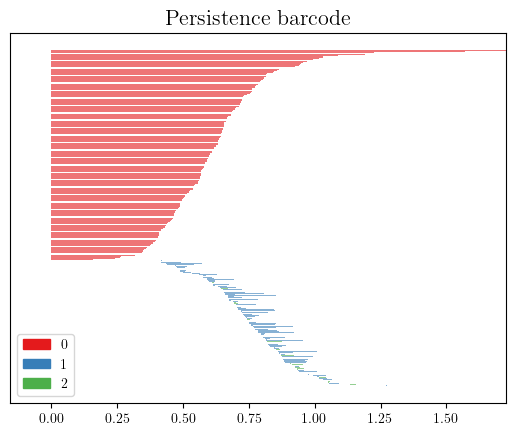

In [80]:
# Get rid of the batch dimension as it is not needed here
output = context_vectors_0.squeeze(0)
max_dimension = 3
compute_distances_and_plot_barcode(output, max_dimension)

### Clustering the context vectors to get word clusters

Note that, similar to BERTopic and various results on clustering in embedding space, the following can be used for topic modelling. To reiterate, using DBSCAN is lossy and persistent homology contains more inforamtion than DBSCAN and HDBSCAN. 

In [81]:
eps = 0.45
min_samples = 3
cluster_and_get_words(context_vectors_0, text_0, eps, min_samples)

{0: ['set', 'on', 'way', '##vor', 'to'],
 3: ['.', '.', '.'],
 1: ['path',
  'sight',
  'of',
  'wildlife',
  'inhabit',
  'to',
  'top',
  'landscape',
  'from',
  'rolling',
  'hills',
  'to',
  'deep',
  'bite',
  'to',
  'eat',
  'stories'],
 2: ['.', '.', '.', '.'],
 5: ['they', 'they', 'they'],
 4: ['stretched', 'far', 'see']}

---

## Analyzing Keyphrases with Persistent Homology

Now, suppose we want to analyze the persistent homology of some keyphrase of the text such as "the clear blue sky" or "the deep blue sea", a phrase of words where the words appear more often than would be expected by chance is often called a "collocation" or "multiword expressions". If the phrase has some hidden meaning that is not discernable from the meanings of the individual words it is composed of, the phrase is often called an "idiom". We are now interested in understanding how to topology of the context vectors of such keyphrases changes when the context (the text it is seen in) changes. Do the relative distances between the words of the keyphrase change, or are they preserved by the model? We can quantify this change by comparing persistence diagrams or barcodes, using the bottleneck or Wasserstein distance metrics. We find in most cases, the Wasserstein distance metric is more suitable for this purpose. 

In [82]:
diagram_0 = compute_phrase_distances_and_homology(context_vectors_1, text[0], "deep blue sea")
print(diagram_0)

[(0, (0.0, inf)), (0, (0.0, 0.956513248524484)), (0, (0.0, 0.7576938647389735))]


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

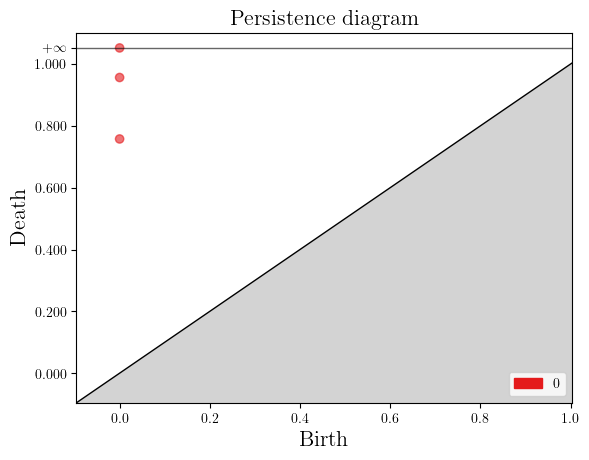

In [83]:
gd.plot_persistence_diagram(diagram_0)

In [84]:
text_1 = text[1]
context_vectors_1 = compute_output(text_1, layer, head)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [85]:
diagram_1 = compute_phrase_distances_and_homology(context_vectors_1, text[1], "deep blue sea")
print(diagram_1)

[(0, (0.0, inf)), (0, (0.0, 1.379910903112847)), (0, (0.0, 1.087934789448628))]


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

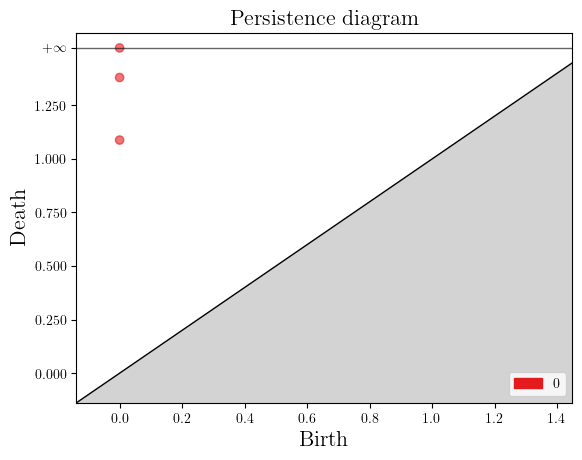

In [86]:
gd.plot_persistence_diagram(diagram_1)

In [87]:
from gudhi.hera import wasserstein_distance

# Compute persistence diagrams
persistence_diagram_0 = compute_phrase_distances_and_homology(context_vectors_0, text_0, "deep blue sea")
persistence_diagram_1 = compute_phrase_distances_and_homology(context_vectors_1, text_1, "deep blue sea")

persistence_diagram_0_separated = separate_by_dimension(persistence_diagram_0)
persistence_diagram_1_separated = separate_by_dimension(persistence_diagram_1)

# Compute Wasserstein distance for each dimension
for dim in persistence_diagram_0_separated.keys():
    wasserstein_distance_value = wasserstein_distance(persistence_diagram_0_separated[dim], persistence_diagram_1_separated[dim])
    print(f'Wasserstein distance for H_{dim}: {wasserstein_distance_value}')


Wasserstein distance for H_0: 0.3872639180759294


---

In [88]:
text_2 = text[2]
context_vectors_2 = compute_output(text_2, layer, head)

text_3 = text[3]
context_vectors_3 = compute_output(text_3, layer, head)

# Compute persistence diagrams
persistence_diagram_2 = compute_phrase_distances_and_homology(context_vectors_2, text_2, "at the top of their game")
persistence_diagram_3 = compute_phrase_distances_and_homology(context_vectors_3, text_3, "at the top of their game")

persistence_diagram_2_separated = separate_by_dimension(persistence_diagram_2)
persistence_diagram_3_separated = separate_by_dimension(persistence_diagram_3)

# Compute Wasserstein distance for each dimension
for dim in persistence_diagram_2_separated.keys():
    wasserstein_distance_value = wasserstein_distance(persistence_diagram_2_separated[dim], persistence_diagram_3_separated[dim])
    print(f'Wasserstein distance for H_{dim}: {wasserstein_distance_value}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions

Wasserstein distance for H_0: 0.7254664158886562


In [89]:
text_2 = text[2]
context_vectors_2 = compute_output(text_2, layer, head)

text_3 = text[3]
context_vectors_3 = compute_output(text_3, layer, head)

# Compute persistence diagrams
persistence_diagram_2 = compute_phrase_distances_and_homology(context_vectors_2, text_2, "pulling rabbits out of hats")
persistence_diagram_3 = compute_phrase_distances_and_homology(context_vectors_3, text_3, "pulling rabbits out of hats")

persistence_diagram_2_separated = separate_by_dimension(persistence_diagram_2)
persistence_diagram_3_separated = separate_by_dimension(persistence_diagram_3)

# Compute Wasserstein distance for each dimension
for dim in persistence_diagram_2_separated.keys():
    wasserstein_distance_value = wasserstein_distance(persistence_diagram_2_separated[dim], persistence_diagram_3_separated[dim])
    print(f'Wasserstein distance for H_{dim}: {wasserstein_distance_value}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions

Wasserstein distance for H_0: 0.6051972668772752


In [90]:
text_4 = text[4]
context_vectors_4 = compute_output(text_4, layer, head)

text_5 = text[5]
context_vectors_5 = compute_output(text_5, layer, head)

# Compute persistence diagrams
persistence_diagram_4 = compute_phrase_distances_and_homology(context_vectors_4, text_4, "pulling rabbits out of hats")
persistence_diagram_5 = compute_phrase_distances_and_homology(context_vectors_5, text_5, "pulling rabbits out of hats")

persistence_diagram_4_separated = separate_by_dimension(persistence_diagram_4)
persistence_diagram_5_separated = separate_by_dimension(persistence_diagram_5)

# Compute Wasserstein distance for each dimension
for dim in persistence_diagram_4_separated.keys():
    wasserstein_distance_value = wasserstein_distance(persistence_diagram_4_separated[dim], persistence_diagram_5_separated[dim])
    print(f'Wasserstein distance for H_{dim}: {wasserstein_distance_value}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions

Wasserstein distance for H_0: 0.39051374526446003
